In [1]:
# prelude
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from pathlib import Path
k_Current_dir = Path.cwd()
k_AssetsDir = "assets"
k_sms_max_len = 100

# Regarding the warning : TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html from .autonotebook import tqdm as notebook_tqdm
# Solution ? 
# ! NOT TESTED YET - Does it apply to Jupyter "in" VSCode ?
# https://saturncloud.io/blog/importerror-iprogress-not-found-please-update-jupyter-and-ipywidgets-although-it-is-installed/
# conda install -c conda-forge ipywidgets
# jupyter nbextension enable --py widgetsnbextension

c:\Users\phili\anaconda3\envs\att\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "labels"}, inplace=True)
    df.rename(columns={"v2": "texts"}, inplace=True)

    df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

    return df

In [3]:
# -----------------------------------------------------------------------------
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [ ]:
# Installer les bibliothèques nécessaires si elles ne le sont pas encore
# !pip install transformers datasets torch scikit-learn

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Charger un modèle BERT pré-entraîné et son tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # binaire (spam vs non-spam)

# Charger votre dataset, ici on utilise un dataset fictif pour l'exemple (spam et non-spam)
# Remplacez cela par votre propre jeu de données
dataset = load_dataset('sms_spam')  # Dataset de spam SMS pour l'exemple

# Prétraitement : tokenization
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Séparer les données en ensemble d'entraînement et de validation
train_dataset, eval_dataset = tokenized_datasets['train'].train_test_split(test_size=0.1).values()

# Définir une fonction pour évaluer les performances du modèle
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Configurer les paramètres d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Utiliser le Trainer de Hugging Face pour entraîner le modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Lancer l'entraînement
trainer.train()

# Évaluation finale
trainer.evaluate()

# Sauvegarder le modèle fine-tuné
model.save_pretrained("./spam_classifier_model")
tokenizer.save_pretrained("./spam_classifier_tokenizer")


In [13]:
# -----------------------------------------------------------------------------
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
df = cleaner(df)
labels = df['labels'].tolist()
texts = df['texts'].tolist()

# BERT - Bidirectional Encoder Representations from Transformers
# It use multiple inputs (input_ids & attention_mask)
# We cannot use model = tf.keras.Sequential([...])

# define both inputs 
# input_ids = id of the token as defined in the pre-trainned model 
# Attention_masks are used to indicate which parts of the sequence should be taken into account by the model
# "Hello, how are you?"
# [7592, 1010, 2129, 2024, 2017, 1029]        input_ids
# [7592, 1010, 2129, 2024, 2017, 1029, 0, 0]  input_ids with padding
# [   1,    1,    1,    1,    1,    1, 0, 0]  attention_masks with padding
input_ids       = Input(shape=(k_sms_max_len,), dtype=tf.int32, name="input_ids")
attention_masks = Input(shape=(k_sms_max_len,), dtype=tf.int32, name="attention_mask")

# Load pretrained model 
# 12-layers, 768-hidden-nodes, 12-attention-heads, 110M parameters
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# Freeze all trainable parameters from all the layers of BERT
# for layer in bert_model.layers:
#     layer.trainable = False

# ! ATTENTION
# If we want to freeze all but NOT the last 2 layers
# BERT basic is made up of 12 stacked layers of transformers 
# Each transformer layer is made up of sub-layers, including attention mechanisms and feed-forward neural networks.
# So before to "unfreeze" the last layer, some research might be required in order to unfreeze the layers correclty
# for layer in bert_model.encoder.layer[-2:]:
#     layer.trainable = False

embeddings = bert_model(input_ids, attention_mask=attention_masks)[0]

# Get the CLS token from the embeddings
cls_token = embeddings[:, 0, :]

# Add a "custom" dense layer with sigmoid activation to BERT
output = Dense(1, activation='sigmoid')(cls_token)

# Define the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

model.summary()

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

# encode sms with BERT tokenizer 
# DONE : make a test with bert-base-uncased then bert-base-cased and compare
# uncased : all tokens in lowercase
# cased   : the model take the case into account
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    
encoded_data = tokenizer(
    texts,
    max_length=k_sms_max_len,
    padding='max_length',       # sequences will be padded according the value of the parameter max_length
    truncation=True,
    return_tensors='tf'
)

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    encoded_data['input_ids'].numpy(), 
    encoded_data['attention_mask'].numpy(), 
    labels, 
    test_size=0.2, 
    random_state=42
)

# convert the datasets into tensors
X_train_ids     = tf.convert_to_tensor(X_train_ids)
X_test_ids      = tf.convert_to_tensor(X_test_ids)
X_train_mask    = tf.convert_to_tensor(X_train_mask)
X_test_mask     = tf.convert_to_tensor(X_test_mask)
y_train         = tf.convert_to_tensor(y_train)
y_test          = tf.convert_to_tensor(y_test)

# Gather encoded data into dictionaries for training
X_train = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
X_test = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

early_stopping = EarlyStopping(
    monitor='val_loss',           # can be 'val_accuracy' if needed 
    patience=3,          
    restore_best_weights=True  
)

# Reduces the learning rate when it stops improving
# helps to converge more quickly to a minimum
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,       # reduction factor of learning rate
    patience=2,       
    min_lr=1e-7       # minimal value for learning rate
)

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_best_model.h5'}")
checkpoint = ModelCheckpoint(
    path,                       # model's path
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)

tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)
print(f"\n\n--------------------------------------------------")
print(f"Once the model runs, open a terminal, make sure you are in the directory of the project and type in : ")
print(f"tensorboard --logdir=logs")
print(f"Then visit the URL")

model.compile(
    optimizer=Adam(learning_rate=3e-5), 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"],       # name=... avoid recall_1 for example
)

history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    validation_data=([X_test['input_ids'], X_test['attention_mask']], y_test),
    batch_size = 32,
    epochs = 50,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard]  
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

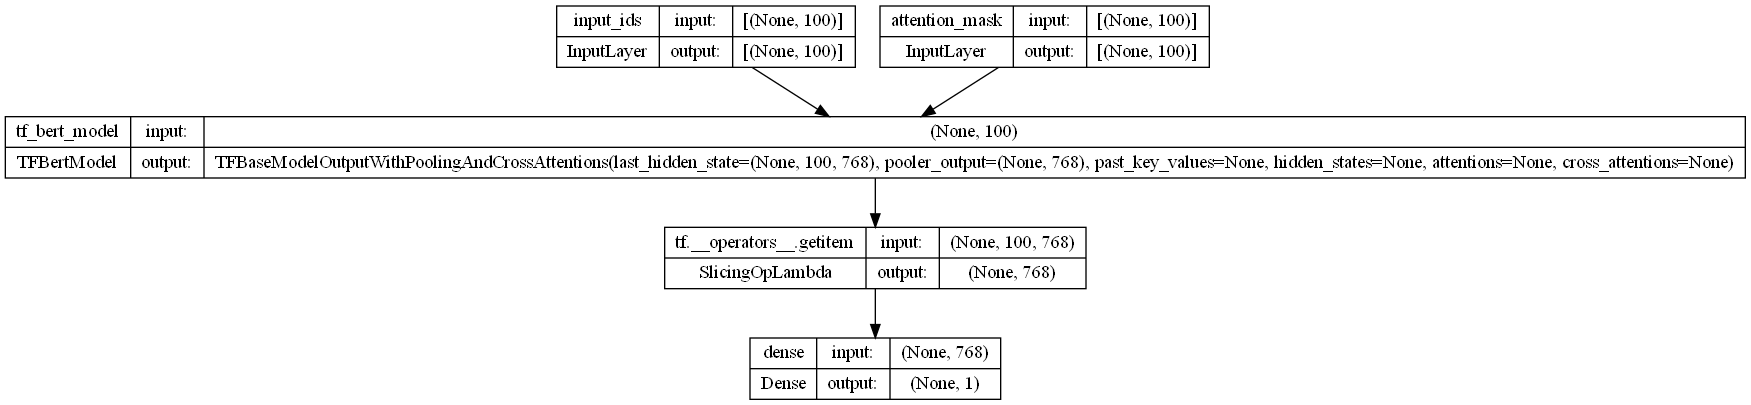

In [5]:
path = Path(f"{k_Current_dir/k_AssetsDir/'bert_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

Saving figure bert_loss


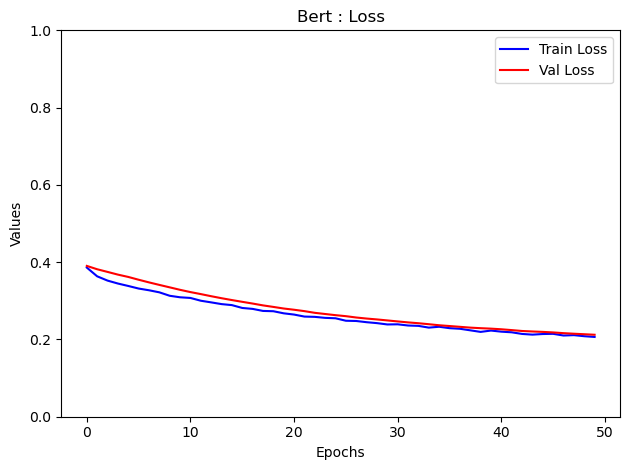

[[0.22013,
  0.218472,
  0.21426,
  0.212454,
  0.214031,
  0.214542,
  0.210136,
  0.211148,
  0.208377,
  0.20649]]

[[0.226311,
  0.224183,
  0.221899,
  0.220611,
  0.21955,
  0.218152,
  0.216276,
  0.21481,
  0.213484,
  0.212139]]

In [6]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("bert_loss", "png")
plt.show()

display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


Saving figure bert_accuracy


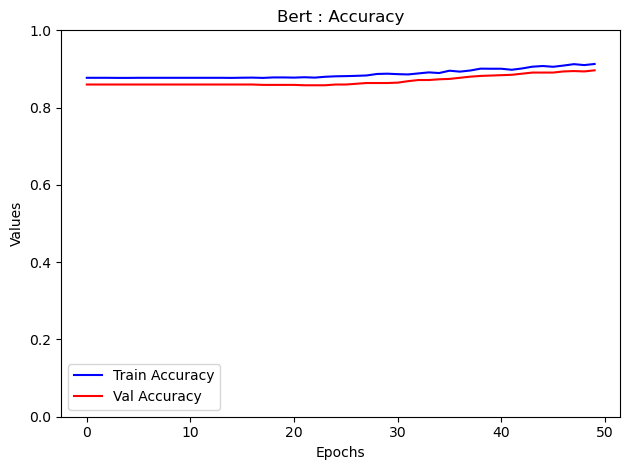

[[0.900605,
  0.897944,
  0.90133,
  0.905925,
  0.907618,
  0.905683,
  0.908827,
  0.912455,
  0.910036,
  0.912938]]

[[0.883946,
  0.884913,
  0.887814,
  0.890716,
  0.890716,
  0.890716,
  0.893617,
  0.894584,
  0.893617,
  0.896518]]

In [7]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("bert_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


Saving figure bert_precision


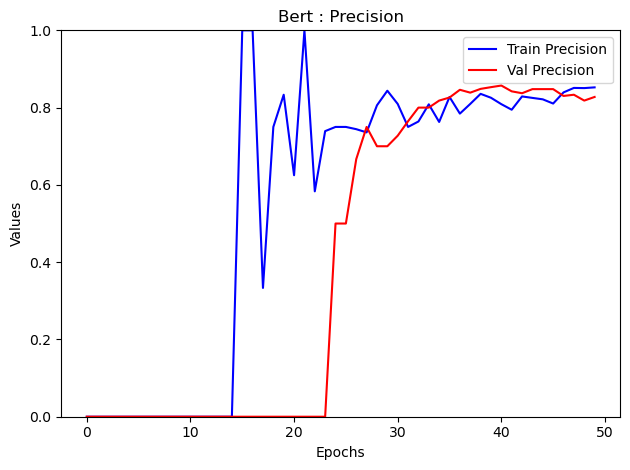

[[0.808917,
  0.794521,
  0.828947,
  0.825137,
  0.821429,
  0.810526,
  0.839378,
  0.850962,
  0.850515,
  0.852381]]

[[0.857143,
  0.842105,
  0.837209,
  0.847826,
  0.847826,
  0.847826,
  0.830189,
  0.833333,
  0.818182,
  0.827586]]

In [8]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Precision")
plt.legend()
plt.ylim(0,1)
save_fig("bert_precision", "png")
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])

Saving figure bert_recall


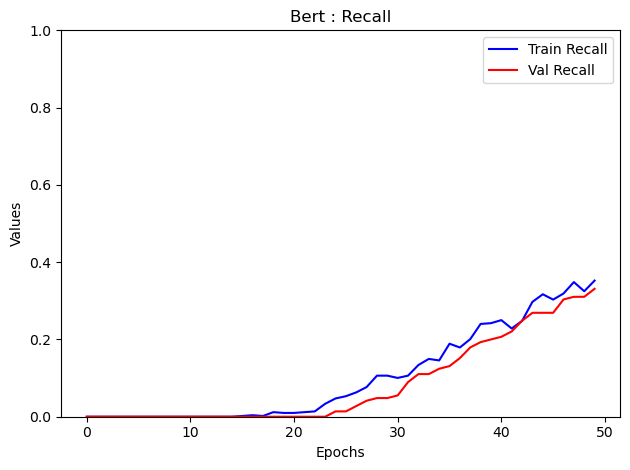

[[0.25,
  0.228346,
  0.248031,
  0.297244,
  0.316929,
  0.30315,
  0.318898,
  0.348425,
  0.324803,
  0.352362]]

[[0.206897,
  0.22069,
  0.248276,
  0.268966,
  0.268966,
  0.268966,
  0.303448,
  0.310345,
  0.310345,
  0.331034]]

In [9]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : Recall")
plt.legend()
plt.ylim(0,1)
save_fig("bert_recall", "png")
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])

In [10]:
def f1_calculus(name, rec, prec):
    df_tmp=pd.DataFrame()
    df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
    return df_tmp

Saving figure bert_f1


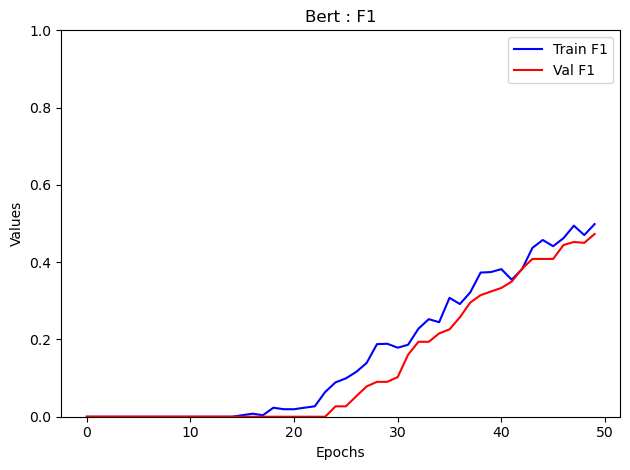

,f1
40,0.381955
41,0.354740
42,0.381818
43,0.437048
44,0.457386
45,0.441261
46,0.462197
47,0.494413
48,0.470085
49,0.498607


,val_f1
40,0.333333
41,0.349727
42,0.382979
43,0.408377
44,0.408377
45,0.408377
46,0.444444
47,0.452261
48,0.450000
49,0.472906


In [11]:
df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert : F1")
plt.legend()
plt.ylim(0,1)
save_fig("bert_f1", "png")
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))

### <span style="color:orange"><b>Comments :</b></span>

* Precision : 0.99 vs 0.98
* Recall    : 0.95 vs 0.89 
* F1        : 0.97 vs 0.93
* With `bert-base-uncased` we are able to keep the Precision while improving the Recall by 6% (& F1 by 4%)
* However 
    * the number of trainable parameters grows from 8_000 to 100 millions
    * the training time grows from 12 sec to 2H

 